#Deep Q learning to play Pong

# Overview
1. What is the project
2. Theory and Algorithm
3. Environment and Lib
4. Game Structure
5. Model Structure
6. Train
7. Test
8. Limitations&Improvements
9. References

# What is the project

In this short project we are gonna **train a neural network to play Pong game** using a reinforcement learning algorithm. 

We will make a program that reads the pixels of the screen and plays the game without any hardcoded rule.  Pong is a two-dimensional sports game that simulates table tennis. The player controls an in-game paddle by moving it vertically across the left or right side of the screen. They can compete against another player controlling a second paddle on the opposing side. Players use the paddles to hit a ball back and forth. The goal is for each player to reach twenty one points before the opponent; points are earned when one fails to return the ball to the other.  R1

# Theory and Algorithm

##Reinforcement learning
Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. Here are some definitions in the RL concept.

**agent:** the one who is learning to win or gather benefits for himself (get more rewards)

**environment: ** the world which agent can interact with. Agent sees states and takes actions based on what he sees.

**reward:** the agent gets rewards or punishments based on his actions. We can think of low reward or negative reward as punishment. Reward can be many things. Even the amount of time the agent stays alive could be considered a reward or score, usually the reward is given to agent (agent does not think and decide what is a reward and what is not)


##Epsilon-greedy
Epsilon-greedy is a simple mixture of exploration and exploitation.

In other words, we choose the action that can maximum the value function with  the probability of 1-$\epsilon $ and randomly choose our action with the probability of $\epsilon $.

##Deep Q Networks

There are already many great works about reinforcement learning which make the computer learn how to play game. One of the algorithms is Q-learning.
Q-learning performs well in some games like Maze. The state-action space is not very large so that we can save them in memory. But here, the combination of the screen pixels and actions is so large that we can't save them in memory, and it takes too long to make the Q-table stable.

Fortunately, some talent people combine the deep learning and reinforcement learning to solve the problem, such as Deep Q Network method. DQN  generalizes the approximation of the Q-value function rather than remembering the solutions. R2

# Environment and Lib

##Installation

In [0]:
!pip install torch
!pip install gym
!pip install atari_py

    100% |████████████████████████████████| 591.8MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61b44000 @  0x7f91ed75e2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 1.5MB 16.3MB/s 
    100% |████████████████████████████████| 1.0MB 19.1MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
    100% |████████████████████████████████| 2.6MB 8.6MB/s 


Because the main point of the project is implementing the DQN algorithm, so we won't build the game from scratch, we just use the environment provided by openAI, gym. The deep learning lib I use here is pytorch, because it's easy to learn and debug.

In [0]:
# Load toolkit
import logging
import gym
import math
import random
import torch
import torch.nn as nn
import torch.optim
import torch.autograd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from env_wrapper import make_atari, wrap_deepmind, wrap_pytorch

USE_CUDA = torch.cuda.is_available() # if we have a gpu to make the compute faster

#  Game structure

In [0]:
# Load game environment
env = gym.make('PongNoFrameskip-v4')
# Reset environment
observation = env.reset()
# Pixel shape
observation.shape

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(210, 160, 3)

The observation is an image of size 210*160 with 3 channels (rgb).

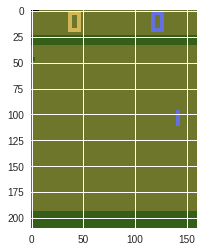

In [0]:
plt.imshow(observation)

Then we take a look at our action space.

In [0]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Although we have 6 discrete action values, there are only three real actions. 0&1 stands for doing nothing. 2&4 refers to going up. 3&5 refers to going down.

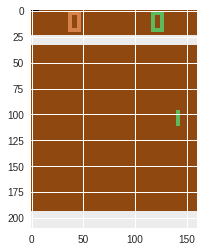

In [0]:
# lets take some steps to see middle game scene in pong game,
# 0 is numeric action to stay at same place 
for i in range(20):
    observation, reward, done, info = env.step(0)# 0 means stay the same place(or do nothing)
    
plt.imshow(observation)

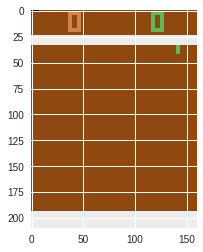

In [0]:
# 2 is numeric action to move paddle up in game
for i in range(20):
    observation2, reward, done, info = env.step(2)# 2 means go up
    
plt.imshow(observation2)

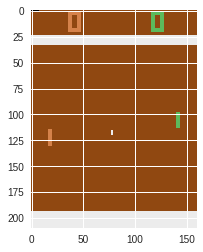

In [0]:
# 3 is numeric action to move paddle down in game
for i in range(20):
    observation3, reward, done, info = env.step(3)# 3 means go down
    
plt.imshow(observation3)

In the game, we control the green paddle which is on the right side. When the ball passes our paddle and goes to end right, we get **reward of -1** for losing. If the ball crosses the opponent and reaches the left, we get a **reward of +1** for winning. The game finishes if one of the players reaches **21 scores**.

So the definition of the system in reinforcement learning method is clear.

**State** is the screen of game. 

**Action** is going go up, go down and stay still.

**Goal: **maximize total reward

We warp frames to **84x84 images** as done in the later work and rescale the pixel values.

Next we define a network policy with an architecture that inputs a 84x84 image and chooses an action. 

# Model Structure

We use three convolutional layers and two fully connected layers to construct the **DQN model**. 

In [0]:
class Pong(torch.nn.Module):

    def __init__(self, action_num):
        super(Pong, self).__init__()
        # Three convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Two fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, action_num)
        )

    def forward(self, x):
        # evaluate the network and return the action values 
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        # Return the size of last convolutional layer
        with torch.no_grad():
            feature_num = self.conv(torch.zeros(1, 1, 84, 84)).view(1, -1).size(1)
        return feature_num

    def action(self, state):
        # Choose action based on max action values
        state = to_tensor(state)
        if USE_CUDA:
            state = state.cuda()
        q_values = self.forward(state)
        return q_values.max(1)[1].data[0]

You can define any network model as you want. Based on architecture and complexity of your model, it may train slow or fast, or even not train at all (too hard to train).

In [0]:
Pong(6)  # show the structure of the network

Pong(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

# Train

## Defining loss

The loss is the squared loss: **${(Q\_ real-Q\_ expected)}^{2}$**, as the code below. We can use the loss function to calculate gradient and optimize our DQN model.


In [0]:
def train():
    # Train begin
    # Sample batch data
    state, action, reward, next_state, done = zip(*random.sample(replay_buffer, batch_size))
    state = np.concatenate(state)
    next_state = np.concatenate(next_state)
    
    # Calculate loss
    # Input the data as tensors
    state = torch.Tensor(state)
    next_state = torch.Tensor(next_state)
    action = torch.LongTensor(action)
    reward = torch.Tensor(reward)
    done = torch.Tensor(done)
    # Use CUDA
    if USE_CUDA:
        state = state.cuda()
        next_state = next_state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        done = done.cuda()
    # Calculate Q values based on the model
    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    # Set expected_q_value
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    # Set loss
    loss = (q_value - expected_q_value).pow(2).mean()

    # Clear grad
    optimizer.zero_grad()
    # Backward
    loss.backward()
    # Grad step
    optimizer.step()
    # Train end

##Hyper parameters

Below are some hyper parameters and basic parameters that will be used in the training process.

**Batch_size:** How many rounds we play before updating the weights of our network.

**Gamma:** The discount factor we use to discount the effect of old actions on the final result. 

**Epsilon_begin:** Exploration rates at the beginning

**Epsilon_end:** Exploration rates at the end

**Epsilon_decay:** The speed of decreasing the exploration rates

**Replay_buffer_size:** The maximum number of data that our buffer can hold. If the the length of the data is larger than this size, we should drop oldest data point to make room for new data.

**Replay_initial:** The size of the first buffer before we begin to train from the buffer.

**Learning_rate:** The rate at which we learn from our results to compute the new weights. A higher rate means we react more to results and a lower rate means we don’t react as strongly to each result.

In [0]:
logger = logging.getLogger()
# game environment id
env_id = 'PongNoFrameskip-v4'
# env_id = 'Pong-v0'

round = 0
save_every_n_round = 100

render = False

one_round_max_frame = 10000
# Adam optimizer learning rate
learning_rate = 0.00001
# exploration rates at beginning and at the end
epsilon_begin = 1
epsilon_end = 0.02

# Set experience replay buffer size
replay_buffer_size = 100000
replay_initial = 10000
# Set batch size
batch_size = 32
# Set discount
gamma = 0.99

# Output the model
model_file = "batch_"+str(batch_size)+"_pong.model"
file_handler = logging.FileHandler(str(batch_size)+".log")
file_handler.setLevel(logging.INFO)
logger.setLevel(logging.INFO)
logger.addHandler(file_handler)

def to_tensor(I):
    return torch.Tensor(I).unsqueeze(0)

## Training process

The crux of our algorithm is going to live in a loop where we continually make a move and then learn based on the results of the move. We’ll put everything in a while block for now but in reality you might set up a break condition to stop the process.

The first step to our algorithm is **preprocessing** the image of the game that OpenAI Gym passed to us. 

In the env.wrapper code, we convert the image format from RGB to GREY because the color is not important to us and GREY format is easy to train. In addition, we resize the image from 210x160x3 to 1x84x84.

The following cell may run very long time , so just be patient, or use the pre trained model to test.
**Uncomment the "break" to run.**

In [0]:
# Accepts a tuple (s,a,r,s') and keeps a list, returns a random batch of tuples as needed
replay_buffer = deque(maxlen=replay_buffer_size)
# Set environment that skip over the 4 observations over all the time steps
env = make_atari(env_id)
# Configure environment for DeepMind-style Atari
env = wrap_deepmind(env)
# Set the environment that can be used in pytorch
env = wrap_pytorch(env)
model = Pong(env.action_space.n)
if USE_CUDA:
    model = model.cuda()
# Train step
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Set the initial exploration rate
epsilon = epsilon_begin
epsilon_decay = 30000
# Decay exploration from 1 to 0.02
import math
epsilon_by_frame = lambda frame_idx: epsilon_end + (epsilon_begin - epsilon_end) * math.exp(-1. * frame_idx / epsilon_decay)
frame_seq = 0
round_reward = 0
# while True:
for _ in range(2000):
    # break
    # reset environment
    state = env.reset()
    # state = pre_process(state)
    # state = np.concatenate([state, state])

    round_over = False
    # Runing until the game round over
    while not round_over:
        # Set exploration rate
        epsilon = epsilon_by_frame(frame_seq)
        # behave according to an epsilon greedy policy
        action = env.action_space.sample()
        if random.random() > epsilon:
            action = model.action(state)
        # agent takes the action, and the environment responds
        next_state, reward, done, _ = env.step(action)
        round_over = done
        # next_state = pre_process(next_state)
        # next_state = np.concatenate([state[80:], next_state])

        # push to replay buffer
        s = np.expand_dims(state, 0)
        ns = np.expand_dims(next_state, 0)
        replay_buffer.append((s, action, reward, ns, done))
        # update the state
        state = next_state
        frame_seq += 1
        # print(frame_seq)
        # Gather the rewards
        round_reward += reward
        # Start training when there are enough memory exists
        if len(replay_buffer) > replay_initial:
            train()

        if frame_seq % 10000 == 0:
            # print("saving model", frame_seq)
            logger.info("current round: "+str(round)+"saving model")
            # from datetime import datetime
            # start = datetime.now()
            torch.save(model, model_file)
            # print(datetime.now() - start)
    # Caculate round number
    round += 1
    # print("round over", round_reward)
    logger.info("round reward: "+str(round_reward))
    round_reward = 0

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Results of training

We write a script to save the model in the file and log rewards from time to time. 

In [0]:
# Read the log trail
def read_log(filename):
    results = []
    with open(filename) as f:
        for line in f:
            if line.startswith("round reward"):
                reward = line.replace("\n", "").replace("\r", "").replace("round reward: ", "")
                results.append(float(reward))
    return results

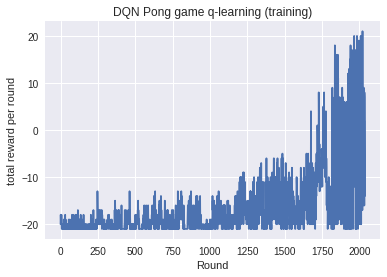

In [0]:
# Plot the result
plt.plot(read_log("32.log"))  # reward of the train process
plt.xlabel('Round')
plt.ylabel('total reward per round')
plt.title('DQN Pong game q-learning (training)')
plt.show()

##Interpretation
We can see that the agent has learned some tricks to defend and even win. From the above figures, we can figure out that at the beginning, the total rewards of the agent in one episode are around -20, which means the agent is losing the game. The reason is that with the relatively large epsilon, the agent is likely to explore more possibilities. However, with the increase of the number of game round, the rewards become larger. After around 1750 steps for batch size 32, the rewards turn positive and even reach 20, which means the agent begins to win. It can be explained that with the decay of the epsilon, the agent is prone to exploit rather than explore, leading to the higher rewards.

# Test

Let's check out the model we trained to see whether it can beat the hard coded AI or not.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type Pong. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning

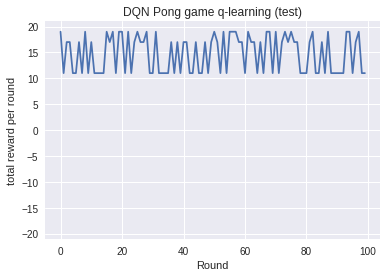

we win at rate  1.0


In [0]:
# Load the model
pong = torch.load("batch_32_pong.model")
# Set test rounds
test_rounds = 100
win_num = 0
score = []
current = 0
for round in range(test_rounds):
    # reset the environment
    state = env.reset()
    current = 0
    round_over = False
    # Running until the round over
    while not round_over:
#         env.render()
        # Running greedy 
        action = pong.action(state)
        # agent takes the action, and the environment responds
        next_state, reward, round_over, _ = env.step(action)
        # Caculate round reward
        current += reward
        # Update state
        state = next_state
    # Calculate number of victory
    if reward > 0:
        win_num+=1
    score.append(current)
# Plot the result
plt.plot(score)
plt.xlabel('Round')
plt.ylabel('total reward per round')
plt.title('DQN Pong game q-learning (test)')
plt.ylim((-21,21))
plt.show()
# Print the wining rate
print("we win at rate ", win_num/test_rounds)

##Interpretation
Now, we can see that the total reward per round are all above 0, which means we win the game every time. However, the mean reward is around 15, which means we cannot hit the ball back every time. 

##Results

In [0]:
# Let us view the game
# Play the mp4 file
import io
import base64
from IPython.display import HTML

video = io.open('test.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

#Limitations

**1. The training process is too long.** With GPU, it takes us a whole day to train the model.

**2. The score result is not as high as we expected.** The mean score of our model does not reach 21, which means the trained agent does not always hit the ball back every time. 

#Next steps
Here are some ideas to improve the training process and agents:

**1.Generate simulations of batches in parallel. ** I tried using multithreading to generate and play batches of games at the same time to increase the speed of training process. The problem was that the backend library for the game had issues creating environments in multiple threads. Maybe you can overcome this by implementing a multiprocess method.

**2.Giving a reward to the agent for catching the ball could be good **for not losing (for example a +0.5 reward). Now we are just giving positive reward to agent for scoring. If it catches the ball and then gets a -1 reward, it will think it is probably bad to catch the ball. 


**3. Use a different gamma to train the model.** In our model, we use 0.99 as gamma. We may try other values for the gamma parameter, for example, 0.9. This may improve the training speed.


# References

1. Wikipedia. https://en.m.wikipedia.org/wiki/Pong
2. Jonathan Hui: Medium. https://medium.com/@jonathan_hui/rl-dqn-deep-qnetwork-
e207751f7ae4
3. Xiaowen Shi: Jianshu. https://www.jianshu.com/p/10930c371cac
4. Andrej Karpathy: github. http://karpathy.github.io/2016/05/31/rl/
5. Timothy Lee: github. https://github.com/openai/baselines
6. higgsfield: github. https://github.com/higgsfield/RL-Adventure
7. Ilya Makarov , Andrej Kashin, and Alisa Korinevskaya: Learning to Play Pong
Video Game via Deep Reinforcement Learning. Russian Science Foundation,
17-11-01294
8. Lior Motorin, Peleg Tuchman: Using Q-Learning to play Pong.
9. Soroush: github. https://github.com/thinkingparticle/deep_rl_pong_keras
10. Dhruv Parthasarathy, Medium. https://medium.com/@dhruvp/how-to-write-aneural-
network-to-play-pong-from-scratch-956b57d4f6e0
11. Max Lapan, Medium. https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55